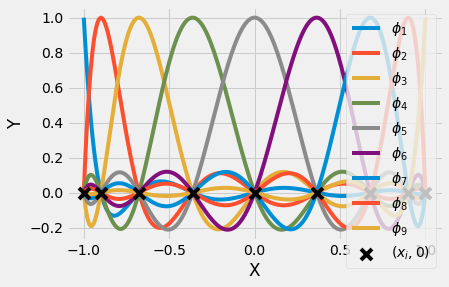

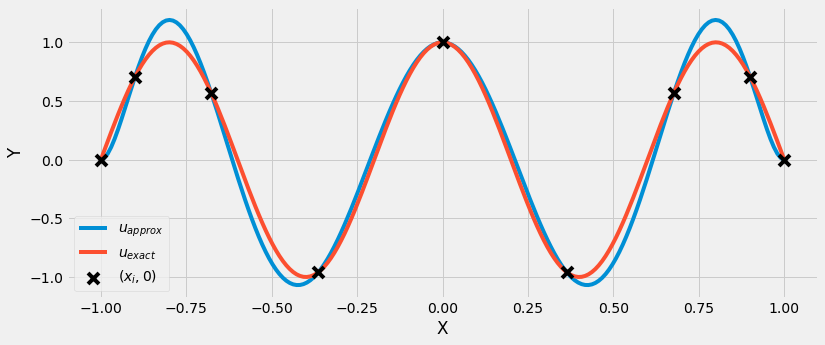

In [1]:
# let f denote the function which we wish to project over [-1,1] = Omega
# Then let RHS_k = \int_\Omega (f \phi_k) dx where phi_k is the lagrange interpolant 1 at x_k and 0 otherwise
# We need to define quadrature: gll_quad(N, func)

from scipy.special import legendre 
from scipy import poly1d
from numpy import flip, polymul, cos, pi, arange, float64, sort, matrix, zeros, linspace
from numpy.polynomial.polynomial import polyder
from matplotlib import pyplot

def jscipypolyder(poly):
    tmp = poly.coefficients
    tmp = flip(tmp)
    tmp = polyder(tmp)
    return(poly1d(flip(tmp)))

def jscipypolymult(poly1, poly2):
    tmp1 = poly1.coefficients
    tmp2 = poly2.coefficients   
    return(poly1d(polymul(tmp1, tmp2)))

def gll_nodes_weights(N):
    legendre_n = legendre(N, monic=False)
    legendre_n_dx = jscipypolyder(legendre_n)
    f = jscipypolymult(poly1d([1.,0.,-1.]), legendre_n_dx)
    fdx = jscipypolyder(f)
    
    gll_nodes = float64(cos(pi*arange(0,N+1)/N))    # initial guess of GLL node locations
    gll_nodes_old = float64(0.*gll_nodes+2)   # initialize x_zeros_old to something bad to get into while loop

    # find (N+1) roots of f = (1-x^2)Ln_{N}'(x) by Newton-Raphson
    max_loop = 1E6
    max_loop_count = 0
    while(max(abs(gll_nodes-gll_nodes_old))>1.E-15):    # while error is greater than epsilon
        gll_nodes_old = gll_nodes
        gll_nodes = gll_nodes_old - ( f(gll_nodes_old)/fdx(gll_nodes_old) )  # Newton update
        max_loop_count += 1
        if max_loop_count > max_loop:
            print("Error = " + str(max(abs(gll_nodes-gll_nodes_old))))
            break

    gll_nodes = sort(gll_nodes)
    gll_weights = 2.0 / ( N*(N+1)*( legendre_n(gll_nodes)**2 ) )
    
    return(gll_nodes, gll_weights)
    

def gll_quad(N, func): # numerically integrates \int_{-1}^{1} func(x) dx by GLL N-point quadrature
    gll_nodes, gll_weights = gll_nodes_weights(N)
    return sum(gll_weights * func(gll_nodes))
    
def lagrange_interpolant(x_vals, y_vals):
    basis = [poly1d([0,1.0])]*len(x_vals)
    if len(x_vals) != len(y_vals):
        print("Error: x and y arrays must have same dimesions")
        
    for y_count in range(0, len(x_vals)):
        poly_num = poly1d([0,1.0])
        poly_den = poly1d([0,y_vals[y_count]])
        for x_count in range(0, len(x_vals)):
            if (x_count != y_count):
                poly_num = jscipypolymult(poly_num, poly1d([1.0, -x_vals[x_count]]) )
                poly_den = jscipypolymult(poly1d([0,1/(x_vals[y_count]-x_vals[x_count])]), poly_den)
                
        basis[y_count] = jscipypolymult(poly_num, poly_den)        
    return(basis)

def ref_numerical_mass(basis, N):
    # ref_numerical_mass defines M_{i,j} = \int_{-1}^{1} \phi_j *\phi_i dx 
    #     by means of the (N+1) point GLL quadrature rule
    mass = zeros((N+1, N+1))
    for row_cnt in range(0, N+1):
        for col_cnt in range(0, N+1):
            temp = gll_quad(N, lambda x: basis[row_cnt](x) * basis[col_cnt](x))
            if abs(temp) > 6.E-15:
                mass[row_cnt, col_cnt] = temp
    
    return mass

def ref_numerical_rhs(func, basis, N):
    # ref_numerical_RHS integrates \int_{-1}^{1} (func * \vec{\phi}) dx by 
    #     means of the (N+1) point GLL quadrature rule
    rhs = [None] * (N+1)
    for mode_cnt in range(0, N+1):
        rhs[mode_cnt] = gll_quad(N, lambda x: func(x) * basis[mode_cnt](x) )
        
    return rhs        
    

def plot_nodes_basis(nodes, basis):
    xs = linspace(-1,1,200)
    # setting a style to use 
    pyplot.style.use('fivethirtyeight') 

    for mode_cnt in range(0,N+1):
        pyplot.plot(xs, basis[mode_cnt](xs), label=r'$\phi_{}$'.format(mode_cnt+1), zorder=1)  

    pyplot.scatter(nodes, 0.*nodes, marker="x", color="black", s=120, zorder=2, label=r'$(x_i,0)$')

    pyplot.legend(loc ="best") 
    pyplot.xlabel("X") 
    pyplot.ylabel("Y") 
    pyplot.show() 

    pyplot.rcParams['figure.figsize'] = [12, 5]
    return
    
def plot_ref_approx(coeff_approx, func_to_project, nodes, basis, N):
    xs = linspace(-1,1,200)
    ys = 0.0 * xs
    for mode_cnt in range(0, N+1):
        ys += coeff_approx[mode_cnt] * basis[mode_cnt](xs)
        
    # setting a style to use 
    pyplot.style.use('fivethirtyeight') 
    pyplot.plot(xs, ys, label=r'$u_{approx}$', zorder=1)  
    pyplot.plot(xs, func_to_project(xs), label=r'$u_{exact}$', zorder=1)  
    
    pyplot.scatter(nodes, coeff_approx, marker="x", color="black", s=120, zorder=2, label=r'$(x_i,0)$')

    pyplot.legend(loc ="best") 
    pyplot.xlabel("X") 
    pyplot.ylabel("Y") 
    pyplot.show() 

    pyplot.rcParams['figure.figsize'] = [12, 5]
    return
   

#################################################################################################
#################################################################################################

# Main

N = 8
func_to_project = lambda x: cos(5/2*pi*x)

gll_nodes, gll_weights = gll_nodes_weights(N)
my_basis = lagrange_interpolant(gll_nodes, 0.*gll_nodes+1)   
plot_nodes_basis(gll_nodes, my_basis)
rhs = ref_numerical_rhs(lambda x: func_to_project(x), my_basis, N)

my_mass = ref_numerical_mass(my_basis, N)
u_approx = [None]*(N+1)
for mode_cnt in range(0, N+1):
    u_approx[mode_cnt] = rhs[mode_cnt] / my_mass[mode_cnt, mode_cnt]
    
plot_ref_approx(u_approx, func_to_project, gll_nodes, my_basis, N)
    

